# Mueller matrix from Mie Scattering

## Install PymieScatt if on google colab
- <a href="https://pymiescatt.readthedocs.io/en/latest/">PyMieScatt: Python Mie code document</a>
- <a href="https://www.sciencedirect.com/science/article/pii/S0022407317305836">PyMieScatt reference</a>
- Installation through conda: conda install -c conda-forge pymiescatt
- through pip: !pip install PyMieScatt

In [ ]:
!pip install PyMieScatt

## Load modules 

In [6]:
import PyMieScatt as ps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Extinction, Scattering, Absorption Efficiencies

- Note that the input value for MieQ is wavelength and particle diameter. 

In [3]:
#test one case
wavelength=375
diameter=300
nc=1.77+0.63j #complex refractive index
ps.MieQ(nc,wavelength, diameter,asDict=True) 
#check it is diameter of radius?

{'Qext': 2.8584971991564117,
 'Qsca': 1.3149276685170943,
 'Qabs': 1.5435695306393173,
 'g': 0.7251162362148784,
 'Qpr': 1.905021797266491,
 'Qback': 0.20145510481352577,
 'Qratio': 0.1532062254349824}

## Phase matrix

MatrixElements compute phase matrix 
- S11, S12, S33, S34 as as function of cosine scattering angle
- check normalization of the phase matrix
- check asymmetry factor 

S11 is defined in  <a href="https://pymiescatt.readthedocs.io/en/latest/forward.html#functions-for-single-particles"> PyMieScatt document </a> as ![title](https://pymiescatt.readthedocs.io/en/latest/_images/math/0f4940ef35bccebe55f5c36989412735f5ad3e07.png)

In [12]:
#test one case
wavelength=375
diameter=300
nc=1.77+0.63j #complex refractive index
nw=1.33+0j
ps.MieQ(nc,wavelength, diameter,asDict=True) 
#check it is diameter of radius?
mu=1.0
S11, S12, S33, S34=ps.MatrixElements(nc/nw,wavelength,diameter,mu) 
print(S11, S12, S33, S34)

12.818983958021121 0.0 (12.818983958021121+0j) 0j


## Load GNP refractive index

In [13]:
url = "https://refractiveindex.info/data_csv.php?datafile=data/main/Au/Rakic-BB.yml"
df1 = pd.read_csv(url)

#reorganize data
#original data with n and k in the same columne
index1=df1.index[df1.n=='k'].tolist()[0]
df2=df1[:index1].astype(float)
df2['k']=df1[index1+1:].n.values.astype('float')
df1=df2

#if data are downloaded and stored in local file
#df1=pd.read_csv('./Rakic-BB.csv')
#df1=df1.drop(columns=['wl.1'])
#df1.columns=["Wavelength", "n", "k"]

#change column name and use only wavelength less than 800nm
df1.columns=["Wavelength", "n", "k"]
df1.Wavelength=df1.Wavelength*1000
df1=df1[df1['Wavelength']<800]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 0 to 72
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Wavelength  73 non-null     float64
 1   n           73 non-null     float64
 2   k           73 non-null     float64
dtypes: float64(3)
memory usage: 2.3 KB


### interpolate wavelength to regular grids

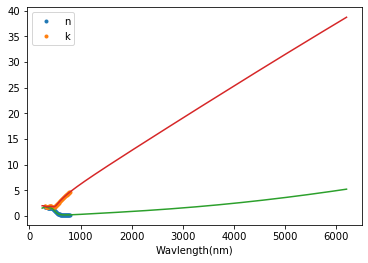

In [54]:
from scipy.interpolate import interp1d

wv=df2.Wavelength[::1].values
#n array
nv=df2.n[::1].values
#k array
kv=df2.k[::1].values

fn = interp1d(df2.Wavelength, df2.n)
fk = interp1d(df2.Wavelength, df2.k)

#interpolate to regular wavelength scale
#wv2=np.linspace(250,790,55)
wv2=np.linspace(300,790,50)
nv2=fn(wv2)
kv2=fk(wv2)

plt.plot(wv2, nv2,'.', label='n')
plt.plot(wv2, kv2,'.', label='k')
plt.plot(wv, nv)
plt.plot(wv, kv)
plt.xlabel("Wavlength(nm)")
plt.legend()

### Compute phase matrix

In [55]:
d1=40 #GNP diameter
angv=np.linspace(0,180,181)
mu=np.cos(angv*np.pi/180.0)

#Relative refractive index in water
qv1=np.array([ps.MieQ((nv2[i]+kv2[i]*1.0j)/nw,wv2[i],d1,asDict=True) for i in range(len(wv2))])
print(qv1.shape)
qscav=np.array([qv1[i]['Qsca'] for i in range(len(wv2))])

mv1=np.array([[ps.MatrixElements((nv2[i]+kv2[i]*1.0j)/nw,wv2[i],d1,mu[j]) for j in range(len(mu))]for i in range(len(wv2))])
print(mv1.shape)
elementv=['S11', 'S12', 'S33', 'S34']
elementv2=['S11', 'S12/S11', 'S33/S11', 'S34/S11']

(50,)
(50, 181, 4)


Text(0.5, 1.0, 'GNP Diameter 40.0 nm')

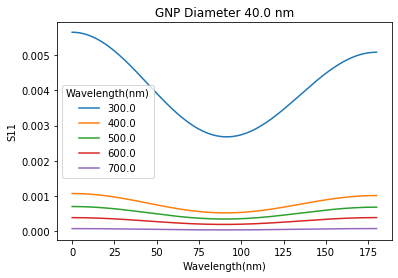

In [57]:
im=0
for iwv in range(0,50,10):
    plt.plot(angv,mv1[iwv,:,im], label=wv2[iwv])
plt.legend(title='Wavelength(nm)')
plt.xlabel("Wavelength(nm)")
plt.ylabel(elementv2[im])
plt.title("GNP Diameter %3.1f nm"%d1)
#not sure how to normalize

Text(0.5, 1.0, 'GNP Diameter 40.0 nm')

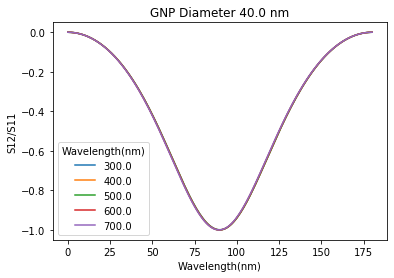

In [49]:
im=1
for iwv in range(0,50,10):
    plt.plot(angv,mv1[iwv,:,im]/mv1[iwv,:,0], label=wv2[iwv])
plt.legend(title='Wavelength(nm)')
plt.xlabel("Wavelength(nm)")
plt.ylabel(elementv2[im])
plt.title("GNP Diameter %3.1f nm"%d1)

Text(0.5, 1.0, 'GNP Diameter 40.0 nm')

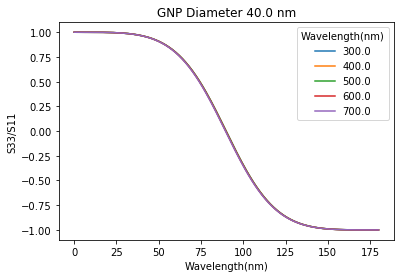

In [52]:
im=2
for iwv in range(0,50,10):
    plt.plot(angv,mv1[iwv,:,im]/mv1[iwv,:,0], label=wv2[iwv])
plt.legend(title='Wavelength(nm)')
plt.xlabel("Wavelength(nm)")
plt.ylabel(elementv2[im])
plt.title("GNP Diameter %3.1f nm"%d1)

Text(0.5, 1.0, 'GNP Diameter 40.0 nm')

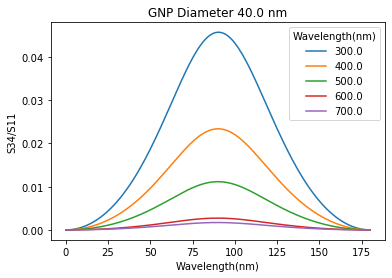

In [53]:
im=3
for iwv in range(0,50,10):
    plt.plot(angv,mv1[iwv,:,im]/mv1[iwv,:,0], label=wv2[iwv])
plt.legend(title='Wavelength(nm)')
plt.xlabel("Wavelength(nm)")
plt.ylabel(elementv2[im])
plt.title("GNP Diameter %3.1f nm"%d1)